<h1 style="color:#191970; font-size:38px">MIMO-NN1</h1>

<h1 style="color:#006400">Tools</h1>

<h1 style="color:#FF5733 ; font-size:15px"> CommPy</h1> is an open source toolkit implementing digital communications algorithms in Python using NumPy and SciPy.

In [1]:
pip install scikit-commpy

Note: you may need to restart the kernel to use updated packages.


<h1 style="color:#006400">Libraries</h1>

In [2]:
from statistics import mean
import numpy as np
from numpy.random import *
from numpy import *
from numpy.linalg import inv
from commpy.utilities import *
from commpy.modulation import QAMModem
from commpy.channels import *
from commpy.links import *
from math import *
import matplotlib.pyplot as plt
import time 

<h1 style="color:#006400">Functions</h1>

### 1. High Power Amplifier Output  

In [3]:
def hpa_sspa_modif_rapp(vin,Vsat,p,q,G,A,B):
    A=-345
    a0=abs(vin)
    theta=np.angle(vin)
    Am=(G*a0)/((1+(G*a0/Vsat)**(2*p))**(1/(2*p)))
    Bm=(A*(a0**q))/((1+(a0/B)**(q)))
    vout=Am*np.exp(1j*(theta+Bm))
    return(vout)
    

### 2. Non Linear Distortion Parameters  

In [4]:
def find_K0_sigma2_d(vin,vout):
    K0 = np.mean(vout*np.conj(vin))/np.mean(np.absolute(vin)**2)
    sigma2_d = np.var(vout - K0*vin)
    return(K0,sigma2_d)

<h1 style="color:#006400">Basic PA Non linear Distortion Model </h1>

In [5]:
IBO=1
p=1.1
q=4
Vsat=1.9
G=16
A=-345
B=0.17
val_IBO_m1dB=((1/np.sqrt(10**-0.1))**(2*p)-1)**(1/(2*p))*Vsat/(G)
coeff_IBO_m1dB=val_IBO_m1dB*np.sqrt(10**(-IBO/10))
s=np.random.randn(1,1000000)
vin1 = np.sqrt(1/2)*(s+1j*s)
vin01 = coeff_IBO_m1dB*vin1
a0=np.absolute(vin01)
a02=a0**2  
theta=np.angle(vin01)
Am=(G*a0)/((1+(G*a0/Vsat)**(2*p))**(1/(2*p)))
Bm=(A*(a0**q))/((1+(a0/B)**(q)))
Sm=Am*np.exp(1j*(Bm))
vout1=Am*np.exp(1j*(theta+Bm))
K0 = np.mean(vout1*np.conj(vin01))/np.mean(np.absolute(vin01)**2)
sigma2_d = np.var(vout1 - K0*vin01) 
print(K0)
print(sigma2_d)

(12.807475337050256-0.44260908822596146j)
0.013477252177032294


<h1 style="color:#006400">Training Dataset </h1>

Generate 1000 H; 
For each H, we have 5000 S (input of NN1) and 5000 X_gd (output of NN1)

In [6]:
Mr=10
Mt=100
M=16
SNRdb=600
N_bits=Mr*np.log2(M)
MSE=np.zeros((Mt,50))
x_gd_amp0=np.zeros((Mt,1))
y_gd_r0=np.zeros([Mt,100])
PAPR_GD=np.zeros((Mt,1))
MUIgdi= np.zeros((Mt,1))
SERgdi=np.zeros((Mt,1))
BERgdi=np.zeros((Mt,1))
GD_Execution_time=0
HH=np.zeros((1,2000))
S=np.zeros((11000,20))
ZZ=np.zeros((11000,10),dtype=complex)
Niter=50
mu1=0.0022
lamda=0.00071
mu2=1
eps=1e-2
x_gd=np.zeros([Mt,1])
X_gd=np.zeros((11000,100))
gdx1=np.zeros([Mt,Niter])
d=np.zeros([Mt,1])
X=np.zeros((11000,200))
H=(1/np.sqrt(2*Mt))*(np.random.randn(Mr,Mt)+1j*np.random.randn(Mr,Mt))
HR=H.flatten()
realh=np.real(HR)
imagh=np.imag(HR)
Hr=np.concatenate((realh,imagh),axis=0).reshape(-1,1)
Hr=np.reshape(Hr, (2000, 1)).T
HH=Hr
for j in range(11000):
    bits = np.random.randint(2, size=int(N_bits))
    QAM16 = QAMModem(16)
    z=QAM16.modulate(bits)
    Z = np.reshape(z, (1, 10)).T
    ZZ[j]=Z.T
    reals=np.real(Z.T)
    imags=np.imag(Z.T)
    s=np.concatenate((reals,imags),axis=1)
    S[j]=s
    ## CDm algo
    for i in range(Niter):
        gdx1=2*np.conj(K0*np.transpose(H)).dot(K0*H.dot(x_gd)+H.dot(d)-Z)
        x_gd=x_gd-mu1*gdx1
        realx=np.real( x_gd)
        imagx=np.imag( x_gd)
        x_z=np.concatenate((realx,imagx),axis=0).T
        X[j]=x_z
        ## HPA 
        val_IBO_m1dB=((1/np.sqrt(10**-0.1))**(2*p)-1)**(1/(2*p))*Vsat/(G)
        coeff_IBO_m1dB=val_IBO_m1dB*np.sqrt((1/np.var(x_gd)))*np.sqrt(10**(-IBO/10))
        vin2=coeff_IBO_m1dB*x_gd
        vout2=hpa_sspa_modif_rapp(vin2,Vsat,p,q,G,A,B)
        K0,sigma2_d=find_K0_sigma2_d (vin2,vout2)
        d=vout2-K0*vin2
        y_gd =np.array(vout2/coeff_IBO_m1dB)
print(X)        

[[ 0.04682881 -0.03173137  0.043474   ... -0.02069963  0.03851596
   0.06499723]
 [ 0.04996113  0.08935958 -0.05109007 ... -0.02925824  0.07467394
   0.0021189 ]
 [ 0.04764407 -0.03142978 -0.03048463 ... -0.03773639  0.06164207
   0.08757741]
 ...
 [-0.08518653 -0.01788912  0.04096724 ... -0.09165516  0.08425084
   0.11171119]
 [ 0.02637403 -0.03916714  0.07906071 ... -0.01522749 -0.06255741
  -0.02338344]
 [-0.03964487 -0.00088811  0.0192098  ... -0.07435374  0.04740593
  -0.0090019 ]]


<h1 style="color:#006400"> Data Normalization </h1>

In [22]:
X_train=S[:8000,:]
y_train=X[:8000,:]

X_test=S[8000:,:]
y_test=X[8000:,:] 


<h1 style="color:#006400"> Artifical Neural Network</h1>

Here owr neural network NN1 for each H
<h1 style="color:#191970; font-size:14px">Input:</h1> 1000 S
<h1 style="color:#191970; font-size:14px">Output:</h1>1000 X_gd
<h1 style="color:#191970; font-size:14px">The activation function selu 'Scaled Exponential Linear' is used for Self-Normalizing Neural Networks </h1>

In [23]:
import keras
from keras.models import Sequential
from keras.layers import Dense,Dropout, Activation, BatchNormalization
import matplotlib.pyplot as plt
model = Sequential()
keras.optimizers.Adamax(learning_rate=0.9, beta_1=0.999, beta_2=0.999)
model.add(Dense(units =30, kernel_initializer = 'uniform', activation = 'tanh', input_dim =20))
model.add(Dense(units =200, kernel_initializer = 'uniform', activation = 'selu'))
model.compile(optimizer = 'Adamax', loss = 'mse', metrics = ['accuracy'])
history =model.fit(X_train, y_train,validation_split=0.3, batch_size=2000, epochs=1000)


Train on 5600 samples, validate on 2400 samples
Epoch 1/1000
5600/5600 [==============================] - 0s 26us/step - loss: 0.0048 - accuracy: 0.0168 - val_loss: 0.0031 - val_accuracy: 0.0496
Epoch 2/1000
5600/5600 [==============================] - 0s 12us/step - loss: 0.0026 - accuracy: 0.0825 - val_loss: 0.0021 - val_accuracy: 0.1492
Epoch 3/1000
5600/5600 [==============================] - 0s 10us/step - loss: 0.0019 - accuracy: 0.1637 - val_loss: 0.0016 - val_accuracy: 0.2304
Epoch 4/1000
5600/5600 [==============================] - 0s 12us/step - loss: 0.0014 - accuracy: 0.2355 - val_loss: 0.0012 - val_accuracy: 0.2937
Epoch 5/1000
5600/5600 [==============================] - 0s 11us/step - loss: 0.0011 - accuracy: 0.3075 - val_loss: 9.4867e-04 - val_accuracy: 0.3608
Epoch 6/1000
5600/5600 [==============================] - 0s 19us/step - loss: 8.6038e-04 - accuracy: 0.3721 - val_loss: 7.5102e-04 - val_accuracy: 0.4313
Epoch 7/1000
5600/5600 [==============================] - 

5600/5600 [==============================] - 0s 9us/step - loss: 6.9599e-05 - accuracy: 0.9134 - val_loss: 7.0745e-05 - val_accuracy: 0.9129
Epoch 106/1000
5600/5600 [==============================] - 0s 9us/step - loss: 6.9585e-05 - accuracy: 0.9136 - val_loss: 7.0716e-05 - val_accuracy: 0.9137
Epoch 107/1000
5600/5600 [==============================] - 0s 9us/step - loss: 6.9557e-05 - accuracy: 0.9136 - val_loss: 7.0693e-05 - val_accuracy: 0.9112
Epoch 108/1000
5600/5600 [==============================] - 0s 13us/step - loss: 6.9536e-05 - accuracy: 0.9129 - val_loss: 7.0680e-05 - val_accuracy: 0.9125
Epoch 109/1000
5600/5600 [==============================] - 0s 9us/step - loss: 6.9507e-05 - accuracy: 0.9134 - val_loss: 7.0638e-05 - val_accuracy: 0.9125
Epoch 110/1000
5600/5600 [==============================] - 0s 10us/step - loss: 6.9481e-05 - accuracy: 0.9132 - val_loss: 7.0619e-05 - val_accuracy: 0.9129
Epoch 111/1000
5600/5600 [==============================] - 0s 9us/step - los

5600/5600 [==============================] - 0s 10us/step - loss: 6.7859e-05 - accuracy: 0.9189 - val_loss: 6.9006e-05 - val_accuracy: 0.9167
Epoch 210/1000
5600/5600 [==============================] - 0s 9us/step - loss: 6.7836e-05 - accuracy: 0.9179 - val_loss: 6.8955e-05 - val_accuracy: 0.9167
Epoch 211/1000
5600/5600 [==============================] - 0s 9us/step - loss: 6.7835e-05 - accuracy: 0.9202 - val_loss: 6.8970e-05 - val_accuracy: 0.9171
Epoch 212/1000
5600/5600 [==============================] - 0s 9us/step - loss: 6.7824e-05 - accuracy: 0.9180 - val_loss: 6.8945e-05 - val_accuracy: 0.9167
Epoch 213/1000
5600/5600 [==============================] - 0s 9us/step - loss: 6.7802e-05 - accuracy: 0.9189 - val_loss: 6.8933e-05 - val_accuracy: 0.9150
Epoch 214/1000
5600/5600 [==============================] - 0s 9us/step - loss: 6.7800e-05 - accuracy: 0.9184 - val_loss: 6.8927e-05 - val_accuracy: 0.9158
Epoch 215/1000
5600/5600 [==============================] - 0s 9us/step - loss

5600/5600 [==============================] - 0s 9us/step - loss: 6.7009e-05 - accuracy: 0.9216 - val_loss: 6.8098e-05 - val_accuracy: 0.9204
Epoch 314/1000
5600/5600 [==============================] - 0s 9us/step - loss: 6.7021e-05 - accuracy: 0.9196 - val_loss: 6.8096e-05 - val_accuracy: 0.9179
Epoch 315/1000
5600/5600 [==============================] - 0s 11us/step - loss: 6.7020e-05 - accuracy: 0.9220 - val_loss: 6.8116e-05 - val_accuracy: 0.9225
Epoch 316/1000
5600/5600 [==============================] - 0s 13us/step - loss: 6.6999e-05 - accuracy: 0.9211 - val_loss: 6.8089e-05 - val_accuracy: 0.9192
Epoch 317/1000
5600/5600 [==============================] - 0s 9us/step - loss: 6.6998e-05 - accuracy: 0.9212 - val_loss: 6.8110e-05 - val_accuracy: 0.9183
Epoch 318/1000
5600/5600 [==============================] - 0s 10us/step - loss: 6.7012e-05 - accuracy: 0.9230 - val_loss: 6.8089e-05 - val_accuracy: 0.9187
Epoch 319/1000
5600/5600 [==============================] - 0s 9us/step - lo

5600/5600 [==============================] - 0s 9us/step - loss: 6.6646e-05 - accuracy: 0.9218 - val_loss: 6.7675e-05 - val_accuracy: 0.9187
Epoch 418/1000
5600/5600 [==============================] - 0s 9us/step - loss: 6.6634e-05 - accuracy: 0.9223 - val_loss: 6.7690e-05 - val_accuracy: 0.9237
Epoch 419/1000
5600/5600 [==============================] - 0s 9us/step - loss: 6.6619e-05 - accuracy: 0.9220 - val_loss: 6.7660e-05 - val_accuracy: 0.9167
Epoch 420/1000
5600/5600 [==============================] - 0s 18us/step - loss: 6.6599e-05 - accuracy: 0.9223 - val_loss: 6.7678e-05 - val_accuracy: 0.9262
Epoch 421/1000
5600/5600 [==============================] - 0s 9us/step - loss: 6.6613e-05 - accuracy: 0.9216 - val_loss: 6.7631e-05 - val_accuracy: 0.9183
Epoch 422/1000
5600/5600 [==============================] - 0s 13us/step - loss: 6.6623e-05 - accuracy: 0.9248 - val_loss: 6.7680e-05 - val_accuracy: 0.9204
Epoch 423/1000
5600/5600 [==============================] - 0s 10us/step - lo

5600/5600 [==============================] - 0s 10us/step - loss: 6.6452e-05 - accuracy: 0.9229 - val_loss: 6.7482e-05 - val_accuracy: 0.9187
Epoch 522/1000
5600/5600 [==============================] - 0s 9us/step - loss: 6.6409e-05 - accuracy: 0.9207 - val_loss: 6.7466e-05 - val_accuracy: 0.9212
Epoch 523/1000
5600/5600 [==============================] - 0s 9us/step - loss: 6.6403e-05 - accuracy: 0.9229 - val_loss: 6.7448e-05 - val_accuracy: 0.9187
Epoch 524/1000
5600/5600 [==============================] - 0s 9us/step - loss: 6.6368e-05 - accuracy: 0.9209 - val_loss: 6.7456e-05 - val_accuracy: 0.9196
Epoch 525/1000
5600/5600 [==============================] - 0s 9us/step - loss: 6.6363e-05 - accuracy: 0.9223 - val_loss: 6.7408e-05 - val_accuracy: 0.9212
Epoch 526/1000
5600/5600 [==============================] - 0s 9us/step - loss: 6.6360e-05 - accuracy: 0.9191 - val_loss: 6.7423e-05 - val_accuracy: 0.9233
Epoch 527/1000
5600/5600 [==============================] - 0s 9us/step - loss

5600/5600 [==============================] - 0s 12us/step - loss: 6.6066e-05 - accuracy: 0.9204 - val_loss: 6.7130e-05 - val_accuracy: 0.9204
Epoch 626/1000
5600/5600 [==============================] - 0s 9us/step - loss: 6.6064e-05 - accuracy: 0.9214 - val_loss: 6.7186e-05 - val_accuracy: 0.9125
Epoch 627/1000
5600/5600 [==============================] - 0s 9us/step - loss: 6.6073e-05 - accuracy: 0.9193 - val_loss: 6.7083e-05 - val_accuracy: 0.9196
Epoch 628/1000
5600/5600 [==============================] - 0s 10us/step - loss: 6.6057e-05 - accuracy: 0.9220 - val_loss: 6.7077e-05 - val_accuracy: 0.9208
Epoch 629/1000
5600/5600 [==============================] - 0s 9us/step - loss: 6.6057e-05 - accuracy: 0.9227 - val_loss: 6.7150e-05 - val_accuracy: 0.9187
Epoch 630/1000
5600/5600 [==============================] - 0s 9us/step - loss: 6.6040e-05 - accuracy: 0.9241 - val_loss: 6.7164e-05 - val_accuracy: 0.9208
Epoch 631/1000
5600/5600 [==============================] - 0s 9us/step - los

5600/5600 [==============================] - 0s 11us/step - loss: 6.5559e-05 - accuracy: 0.9205 - val_loss: 6.6604e-05 - val_accuracy: 0.9154
Epoch 730/1000
5600/5600 [==============================] - 0s 9us/step - loss: 6.5549e-05 - accuracy: 0.9193 - val_loss: 6.6625e-05 - val_accuracy: 0.9208
Epoch 731/1000
5600/5600 [==============================] - 0s 9us/step - loss: 6.5549e-05 - accuracy: 0.9196 - val_loss: 6.6631e-05 - val_accuracy: 0.9162
Epoch 732/1000
5600/5600 [==============================] - 0s 9us/step - loss: 6.5545e-05 - accuracy: 0.9248 - val_loss: 6.6545e-05 - val_accuracy: 0.9142
Epoch 733/1000
5600/5600 [==============================] - 0s 9us/step - loss: 6.5521e-05 - accuracy: 0.9193 - val_loss: 6.6531e-05 - val_accuracy: 0.9167
Epoch 734/1000
5600/5600 [==============================] - 0s 14us/step - loss: 6.5491e-05 - accuracy: 0.9229 - val_loss: 6.6573e-05 - val_accuracy: 0.9137
Epoch 735/1000
5600/5600 [==============================] - 0s 9us/step - los

5600/5600 [==============================] - 0s 9us/step - loss: 6.4897e-05 - accuracy: 0.9189 - val_loss: 6.5920e-05 - val_accuracy: 0.9117
Epoch 834/1000
5600/5600 [==============================] - 0s 9us/step - loss: 6.4877e-05 - accuracy: 0.9191 - val_loss: 6.5964e-05 - val_accuracy: 0.9171
Epoch 835/1000
5600/5600 [==============================] - 0s 9us/step - loss: 6.4896e-05 - accuracy: 0.9198 - val_loss: 6.6000e-05 - val_accuracy: 0.9179
Epoch 836/1000
5600/5600 [==============================] - 0s 9us/step - loss: 6.4885e-05 - accuracy: 0.9205 - val_loss: 6.5942e-05 - val_accuracy: 0.9121
Epoch 837/1000
5600/5600 [==============================] - 0s 9us/step - loss: 6.4918e-05 - accuracy: 0.9180 - val_loss: 6.5900e-05 - val_accuracy: 0.9162
Epoch 838/1000
5600/5600 [==============================] - 0s 9us/step - loss: 6.4834e-05 - accuracy: 0.9220 - val_loss: 6.5950e-05 - val_accuracy: 0.9125
Epoch 839/1000
5600/5600 [==============================] - 0s 9us/step - loss:

5600/5600 [==============================] - 0s 9us/step - loss: 6.4144e-05 - accuracy: 0.9137 - val_loss: 6.5115e-05 - val_accuracy: 0.9121
Epoch 938/1000
5600/5600 [==============================] - 0s 10us/step - loss: 6.4090e-05 - accuracy: 0.9182 - val_loss: 6.5181e-05 - val_accuracy: 0.9096
Epoch 939/1000
5600/5600 [==============================] - 0s 10us/step - loss: 6.4122e-05 - accuracy: 0.9164 - val_loss: 6.5134e-05 - val_accuracy: 0.9129
Epoch 940/1000
5600/5600 [==============================] - 0s 9us/step - loss: 6.4114e-05 - accuracy: 0.9168 - val_loss: 6.5125e-05 - val_accuracy: 0.9142
Epoch 941/1000
5600/5600 [==============================] - 0s 9us/step - loss: 6.4087e-05 - accuracy: 0.9168 - val_loss: 6.5096e-05 - val_accuracy: 0.9054
Epoch 942/1000
5600/5600 [==============================] - 0s 11us/step - loss: 6.4036e-05 - accuracy: 0.9152 - val_loss: 6.5025e-05 - val_accuracy: 0.9104
Epoch 943/1000
5600/5600 [==============================] - 0s 11us/step - l

<h1 style="color:#006400"> Weights Vector of NN1</h1>

In [9]:
first_layer_weights =model.layers[0].get_weights()[0] 
first=first_layer_weights.flatten()
first_layer_biases  = model.layers[0].get_weights()[1]
first_layer=np.concatenate((first,first_layer_biases),axis=0)
second_layer_weights = model.layers[1].get_weights()[0]
second=second_layer_weights.flatten()
second_layer_biases  = model.layers[1].get_weights()[1]
second_layer=np.concatenate((second,second_layer_biases),axis=0)
weights=np.concatenate((first_layer,second_layer),axis=0)
print (len(weights))

4620


<h1 style="color:#006400"> Make Predictions</h1>

In [27]:
y_pred= model.predict(X_train)

In [34]:
y_pred_test = model.predict(X_test)

In [ ]:
from keras.utils import plot_model
plot_model(model, to_file='model.png')

<h1 style="color:#006400"> Accuracy Representation </h1>

In [ ]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.grid(True,which="both", linestyle='--')
plt.ylabel('Accuracy') 
plt.xlabel('Epoch')
plt.legend(['Train', 'val'], loc='upper left')
plt.show()

<h1 style="color:#006400"> Loss Representation</h1>

In [ ]:

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.grid(True,which="both", linestyle='--')
plt.ylabel('Loss') 
plt.yscale('log')
plt.xlabel('Epoch')
plt.legend(['Train','val'], loc='upper left')
plt.show()

<h1 style="color:#006400"> Mean-Squared-Error</h1>

# Train Set

Mean Squred Error: -33.138329647960475


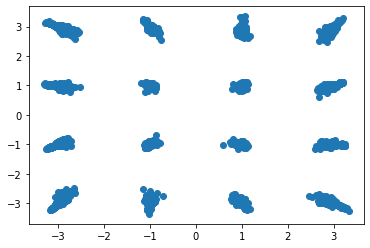

In [38]:
#NMSE_Units=[]
NMSE=np.zeros([1000,1])
recievehh=np.zeros([1000,10],dtype=complex)
Y_gdr=y_pred[:,:100]
Y_gdi=1j*y_pred[:,100:]
Y_gd=Y_gdr+Y_gdi
Shr=X_train[:,:10]
Shi=1j*X_train[:,10:20]
SSh=Shr+Shi
for i in range(1000):
    val_IBO_m1dB=((1/np.sqrt(10**-0.1))**(2*p)-1)**(1/(2*p))*Vsat/(G)
    coeff_IBO_m1dB=val_IBO_m1dB*np.sqrt((1/np.var(Y_gd)))*np.sqrt(10**(-IBO/10))
    vin2=coeff_IBO_m1dB*Y_gd
    vout2=hpa_sspa_modif_rapp(vin2,Vsat,p,q,G,A,B)
    Y_gd_amp = vout2/coeff_IBO_m1dB
    recieveh=(H.dot(x_gd_amp[i])).reshape((10))
    recievehh[i]=recieveh
    NMSE[i]=(np.mean(np.abs(ZZ[i]-recieveh)**2)/np.mean(np.abs(ZZ[i])**2))
    NMSEdb=10*np.log10(np.mean(NMSE[i]))
recievehhh=recievehh.flatten()
realr=np.real(recievehhh)
imagr=np.imag(recievehhh)
plt.scatter(realr,imagr)    
print('Mean Squred Error:', NMSEdb)


# Test Set 

In [39]:
NMSE=np.zeros([1000,1])
recievehh=np.zeros([1000,10],dtype=complex)
Y_gdr=y_pred_test[:,:100]
Y_gdr=y_pred_test[:,:100]
Y_gdi=1j*y_pred_test[:,100:]
Y_gd=Y_gdr+Y_gdi
Shr=X_train[:,:10]
Shi=1j*X_train[:,10:20]
SSh=Shr+Shi
for i in range(1000):
    val_IBO_m1dB=((1/np.sqrt(10**-0.1))**(2*p)-1)**(1/(2*p))*Vsat/(G)
    coeff_IBO_m1dB=val_IBO_m1dB*np.sqrt((1/np.var(Y_gd)))*np.sqrt(10**(-IBO/10))
    vin2=coeff_IBO_m1dB*Y_gd
    vout2=hpa_sspa_modif_rapp(vin2,Vsat,p,q,G,A,B)
    Y_gd_amp = vout2/coeff_IBO_m1dB
    recieveh=(H.dot(x_gd_amp[i])).reshape((10))
    recievehh[i]=recieveh
    NMSE[i]=(np.mean(np.abs(ZZ[i]-recieveh)**2)/np.mean(np.abs(ZZ[i])**2))
    NMSEdb=10*np.log10(np.mean(NMSE[i]))
print(NMSEdb)

-33.138329647960475
